In [63]:
from VariationalBayes import ScalarParam, ModelParamsDict, VectorParam, PosDefMatrixParam
from VariationalBayes.NormalParams import MVNParam, UVNParam, UVNParamVector
from VariationalBayes.GammaParams import GammaParam
from VariationalBayes.ExponentialFamilies import \
    UnivariateNormalEntropy, MultivariateNormalEntropy, GammaEntropy, MVNPrior, UVNPrior, GammaPrior

from autograd import grad, hessian, jacobian, hessian_vector_product
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy as asp
import scipy as sp

import copy
from scipy import optimize

In [24]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.
import os
import json

simulate_data = False
prior_par = ModelParamsDict('Prior Parameters')

# Simulate data
N = 500     # observations per group
K = 5      # dimension of regressors
NG = 500      # number of groups

# Generate data
NObs = NG * N
true_beta = np.array(range(5))
true_beta = true_beta - np.mean(true_beta)
true_y_info = 1.0

true_mu = 0.0
true_mu_info = 40.0
true_u = np.random.normal(true_mu, 1 / np.sqrt(true_mu_info), NG)

x_mat = np.random.random(K * NObs).reshape(NObs, K) - 0.5
y_g_vec = np.array([ g for g in range(NG) for n in range(N) ])
true_mean = np.matmul(x_mat, true_beta) + true_u[y_g_vec]
print true_mean
y_vec = np.random.normal(true_mean, 1 / np.sqrt(true_y_info), NG * N)

prior_par.push_param(VectorParam('beta_mean', K, val=np.full(K, 0.0)))
prior_par.push_param(PosDefMatrixParam('beta_info', K, val=0.01 * np.eye(K)))

prior_par.push_param(ScalarParam('mu_mean', val=0.))
prior_par.push_param(ScalarParam('mu_info', val=0.5))

prior_par.push_param(ScalarParam('mu_info_shape', val=0.5))
prior_par.push_param(ScalarParam('mu_info_rate', val=0.5))

prior_par.push_param(ScalarParam('y_info_shape', val=0.0))
prior_par.push_param(ScalarParam('y_info_rate', val=10.0))

print N * NG

[-0.91584645 -0.24369998  0.06055591 ...,  1.15281629 -0.35266865
 -0.68851525]
40000


In [69]:
# Build an object to contain a variational approximation to a K-dimensional multivariate normal.

# ADVI-style, we will represent each parameter as a univariate normal.
# Note: you need to include the Jacobian of the transform because the log prior is not a density
# with respect to the transformed space.
lmm_par = ModelParamsDict('LMM Parameters')

lmm_par.push_param(MVNParam('beta', K))
lmm_par.push_param(UVNParam('mu'))
lmm_par.push_param(GammaParam('mu_info'))
lmm_par.push_param(GammaParam('y_info'))
lmm_par.push_param(UVNParamVector('u', NG))

lmm_par['beta'].mean.set(np.full(K, -0.2))
lmm_par['beta'].info.set(np.eye(K))

lmm_par['mu'].mean.set(0.2)
lmm_par['mu'].info.set(1.5)

lmm_par['mu_info'].shape.set(2.3)
lmm_par['mu_info'].rate.set(4.1)

lmm_par['y_info'].shape.set(2.4)
lmm_par['y_info'].rate.set(3.1)

lmm_par['u'].mean.set(np.full(NG, -0.1))
lmm_par['u'].info.set(np.full(NG, 0.8))

free_par_vec = lmm_par.get_free()

In [91]:
# Define moment parameters
moment_par = ModelParamsDict('Moment Parameters')
moment_par.push_param(VectorParam('e_beta', K))
moment_par.push_param(PosDefMatrixParam('e_beta_outer', K))
moment_par.push_param(ScalarParam('e_mu'))
moment_par.push_param(ScalarParam('e_mu2'))
moment_par.push_param(ScalarParam('e_mu_info'))
moment_par.push_param(ScalarParam('e_log_mu_info'))
moment_par.push_param(ScalarParam('e_y_info'))
moment_par.push_param(ScalarParam('e_log_y_info'))
moment_par.push_param(VectorParam('e_u', NG))
moment_par.push_param(VectorParam('e_u2', NG))

def set_moments(lmm_par, moment_par):
    moment_par['e_beta'].set(lmm_par['beta'].e())
    moment_par['e_beta_outer'].set(lmm_par['beta'].e_outer())
    moment_par['e_mu'].set(lmm_par['mu'].e())
    moment_par['e_mu2'].set(lmm_par['mu'].e_outer())
    moment_par['e_u'].set(lmm_par['u'].e())
    moment_par['e_u2'].set(lmm_par['u'].e_outer())
    moment_par['e_mu_info'].set(lmm_par['mu_info'].e())
    moment_par['e_log_mu_info'].set(lmm_par['mu_info'].e_log())
    moment_par['e_y_info'].set(lmm_par['y_info'].e())
    moment_par['e_log_y_info'].set(lmm_par['y_info'].e_log())
    
set_moments(lmm_par, moment_par)

# Moment indices.
moment_indices = copy.deepcopy(moment_par)
moment_indices.set_vector(1 + np.array(range(moment_indices.vector_size())))

In [42]:
def ExpectedLogPrior(moment_par, prior_par):
    e_beta = moment_par['e_beta'].get()
    cov_beta = moment_par['e_beta_outer'].get() - np.matmul(e_beta, e_beta.transpose())
    
    e_mu = moment_par['e_mu'].get()
    var_mu = moment_par['e_mu2'].get() - e_mu**2
        
    return \
        MVNPrior(prior_mean=prior_par['beta_mean'].get(),
                 prior_info=prior_par['beta_info'].get(),
                 e_obs=e_beta,
                 cov_obs=cov_beta) + \
        UVNPrior(prior_mean=prior_par['mu_mean'].get(),
                 prior_info=prior_par['mu_info'].get(),
                 e_obs=e_mu,
                 var_obs=var_mu) + \
        GammaPrior(prior_shape=prior_par['mu_info_shape'].get(),
                   prior_rate=prior_par['mu_info_rate'].get(),
                   e_obs=moment_par['e_mu_info'].get(),
                   e_log_obs=moment_par['e_mu_info'].get()) + \
        GammaPrior(prior_shape=prior_par['y_info_shape'].get(),
                   prior_rate=prior_par['y_info_rate'].get(),
                   e_obs=moment_par['e_y_info'].get(),
                   e_log_obs=moment_par['e_log_y_info'].get())

ExpectedLogPrior(moment_par, prior_par)

-5.5584512806374473

In [54]:
def ExpectedRandomEffectLogLikelihood(moment_par):
    e_u = moment_par['e_u'].get()
    e_u2 = moment_par['e_u2'].get()

    e_mu = moment_par['e_mu'].get()
    e_mu2 = moment_par['e_mu2'].get()

    e_log_mu_info = moment_par['e_log_mu_info'].get()
    e_mu_info = moment_par['e_mu_info'].get()
    return -0.5 * e_mu_info * np.sum(e_u2 - 2 * e_u * e_mu + e_mu2) + 0.5 * len(e_u) * e_log_mu_info

ExpectedRandomEffectLogLikelihood(moment_par)

-193.66381502568623

In [89]:
class DataCache(object):
    def __init__(self, x_mat, y_vec, y_g_vec):
        self.x_mat = x_mat
        self.y_vec = y_vec
        self.y_g_vec = y_g_vec
        self.y_t_y = np.dot(np.transpose(y_vec), y_vec)
        self.y_t_x = np.dot(np.transpose(y_vec), x_mat)
        self.x_t_x = np.dot(np.transpose(x_mat), x_mat)
        
        num_g = np.max(y_g_vec)
        k = x_mat.shape[1]
        num_g = np.max(y_g_vec) + 1
        self.num_g = num_g
        self.n_g = np.full(num_g, 0.0)
        self.y_sum_g = np.full(num_g, 0.0)
        self.x_sum_g = np.full((num_g, k), 0.0)
        for g in range(num_g):
            g_rows = np.array(y_g_vec) == g
            self.n_g[g] = np.sum(g_rows)
            self.y_sum_g[g] = np.sum(y_vec[g_rows])
            self.x_sum_g[g, :] = np.sum(x_mat[g_rows, :], 0)
    
data_cache = DataCache(x_mat, y_vec, y_g_vec)

In [90]:
def ExpectedDataLogLikelihood(data_cache, moment_par):
    e_beta = moment_par['e_beta'].get()
    e_beta_outer = moment_par['e_beta_outer'].get()
    
    ll_global_term = \
        data_cache.y_t_y + \
        -2 * np.matmul(data_cache.y_t_x, e_beta) + \
        np.trace(np.matmul(data_cache.x_t_x, e_beta_outer)) 

    e_u = moment_par['e_u'].get()
    e_u2 = moment_par['e_u2'].get()
    
    ll_group_term = np.sum(
        e_u2 * data_cache.n_g[g] + \
        -2 * e_u * data_cache.y_sum_g + \
        2 * e_u * np.matmul(data_cache.x_sum_g, e_beta))

    e_y_info = moment_par['e_y_info'].get()
    e_log_y_info = moment_par['e_log_y_info'].get()
    return -0.5 * e_y_info * (ll_global_term + ll_group_term) + 0.5 * len(y_vec) * e_log_y_info

# These should be equal.
print ExpectedDataLogLikelihood(data_cache, moment_par)

-56013.8055224


In [75]:
def ELBODataTerm(data_cache, moment_par, prior_par):
    ll_data = ExpectedDataLogLikelihood(data_cache, moment_par)
    if np.isnan(ll_data):
        print 'bad data log likelihood'
        return -np.inf

    ll_rf = ExpectedRandomEffectLogLikelihood(moment_par)
    if np.isnan(ll_rf):
        print 'bad random effect log likelihood'
        return -np.inf

    e_log_prior = ExpectedLogPrior(moment_par, prior_par)
    if np.isnan(e_log_prior):
        print 'bad prior'
        return -np.inf

    return ll_data + ll_rf + e_log_prior

def ELBOEntropyTerm(lmm_par):
    return MultivariateNormalEntropy(lmm_par['beta'].info.get()) + \
           UnivariateNormalEntropy(lmm_par['mu'].info.get()) + \
           UnivariateNormalEntropy(lmm_par['u'].info.get()) + \
           GammaEntropy(shape=lmm_par['y_info'].shape.get(),
                        rate=lmm_par['y_info'].rate.get()) + \
           GammaEntropy(shape=lmm_par['mu_info'].shape.get(),
                        rate=lmm_par['mu_info'].rate.get())

def ELBO(data_cache, lmm_par, moment_par, prior_par):
    return ELBODataTerm(data_cache, moment_par, prior_par) + ELBOEntropyTerm(lmm_par)

print ELBODataTerm(data_cache, moment_par, prior_par)
print ELBOEntropyTerm(lmm_par)
print ELBO(data_cache, lmm_par, moment_par, prior_par)

-56213.0277887
315.247506628
-55897.7802821


In [92]:

class KLWrapper(object):
    def __init__(self, lmm_par, moment_par, prior_par, x_mat, y_vec, y_g_vec, num_draws):
        self.__lmm_par_ad = copy.deepcopy(lmm_par)
        self.__prior_par_ad = copy.deepcopy(prior_par)
        self.__moment_par_ad = copy.deepcopy(moment_par)
        self.__data_cache = DataCache(x_mat, y_vec, y_g_vec)

    def KL(self, free_par_vec, verbose=False):
        self.__lmm_par_ad.set_free(free_par_vec)
        set_moments(self.__lmm_par_ad, self.__moment_par_ad)

        #print self.__lmm_par_ad
        kl = -ELBO(self.__data_cache,
                   self.__lmm_par_ad,
                   self.__moment_par_ad,
                   self.__prior_par_ad)[0]
        if verbose: print kl

        return kl


kl_wrapper = KLWrapper(lmm_par, moment_par, prior_par, x_mat, y_vec, y_g_vec, 20)
KLGrad = grad(kl_wrapper.KL)
KLHess = hessian(kl_wrapper.KL)
KLHessVecProd = hessian_vector_product(kl_wrapper.KL)  
print kl_wrapper.KL(free_par_vec)



64376.7188619


In [93]:
class MomentWrapper(object):
    def __init__(self, lmm_par, moment_par):
        self.__lmm_par_ad = copy.deepcopy(lmm_par)
        self.__moment_par = copy.deepcopy(moment_par)

    # Return a posterior moment of interest as a function of unconstrained parameters.
    def GetMoments(self, free_par_vec):
        self.__lmm_par_ad.set_free(free_par_vec)
        set_moments(self.__lmm_par_ad, self.__moment_par)
        return self.__moment_par.get_vector()
    
    def GetMomentParameters(self, free_par_vec):
        self.__glmm_par_ad.set_free(free_par_vec)
        set_moments(self.__glmm_par_ad, self.__moment_par)
        return self.__moment_par
    
moment_wrapper = MomentWrapper(lmm_par, moment_par)
MomentJacobian = jacobian(moment_wrapper.GetMoments)


In [94]:
import timeit

time_num = 10

print 'Function time:'
print timeit.timeit(lambda: kl_wrapper.KL(free_par_vec), number=time_num) / time_num

print 'Grad time:'
print timeit.timeit(lambda: KLGrad(free_par_vec), number=time_num) / time_num

print 'Hessian vector product time:'
print timeit.timeit(lambda: KLHessVecProd(free_par_vec, free_par_vec + 1), number=time_num) / time_num


Function time:
0.000853300094604
Grad time:
0.00725028514862
Hessian vector product time:
0.0171108007431


In [95]:
import time

class OptimizationPath(object):
    def __init__(self):
        self.x_history = []
        pass
    
    def save(self, x):
        self.x_history.append(x)

bfgs_path = OptimizationPath()
init_par_vec = copy.deepcopy(free_par_vec)

# Optimize.
vb_time = time.time()

# print 'Running BFGS'
# vb_opt_bfgs = optimize.minimize(
#     lambda par: kl_wrapper.KL(par, verbose=True), init_par_vec,
#     method='bfgs', jac=KLGrad, tol=1e-2, callback=bfgs_path.save,
#     options={'maxiter': 100, 'gtol': 1e-2, 'disp': True})

trust_path = OptimizationPath()
print 'Running Newton Trust Region'
# trust_init = copy.deepcopy(vb_opt_bfgs.x)
trust_init = copy.deepcopy(init_par_vec)
vb_opt = optimize.minimize(
    lambda par: kl_wrapper.KL(par, verbose=True),
    trust_init, method='trust-ncg', jac=KLGrad, hessp=KLHessVecProd,
    tol=1e-6, callback=trust_path.save, options={'maxiter': 100, 'disp': True, 'gtol': 1e-6 })

vb_time = time.time() - vb_time

lmm_par_opt = copy.deepcopy(lmm_par)
lmm_par_opt.set_free(vb_opt.x)

print 'Done.'

print vb_time / 60

Running Newton Trust Region
64376.7188619
52791.7134334
46493.8114489
40696.7934028
39713.114519
36861.8230784
36647.7759913
33528.8796389
32876.9950303
28367.2448958
28296.311436
23240.3067964
23021.1654357
22911.9727105
41452.8108709
23355.7054008
22652.0454364
26990.9008524
22453.147257
22401.1827732
22163.0105863
29344.6038734
21999.1543407
21708.42161
21223.4096406
20773.0878048
20693.3270821
20592.2705524
20090.608995
20088.2525685
19957.6976912
19957.5071103
19935.8302489
19935.8251315
19935.7925011
19934.6044343
19934.6044084
19934.5685904
19934.5508354
19934.5500588
19934.5500062
19934.5499282
19934.5499282
19934.5499282
         Current function value: 19934.549928
         Iterations: 42
         Function evaluations: 44
         Gradient evaluations: 39
         Hessian evaluations: 0
Done.
0.0926011006037


In [96]:
print lmm_par_opt


LMM Parameters:
	beta:
beta_mean:
[-2.01884278 -0.98893181 -0.0041212   1.01700877  2.00936384]
beta_info:
[[  3.32735694e+03  -1.55010850e+01   2.02698477e+01   3.95733686e+00
    7.53384293e+00]
 [ -1.55010850e+01   3.36729849e+03   8.44998625e+00   2.80682474e+01
    6.06906123e+00]
 [  2.02698477e+01   8.44998625e+00   3.34534140e+03  -9.94247334e+00
    1.03642279e+01]
 [  3.95733686e+00   2.80682474e+01  -9.94247334e+00   3.37691147e+03
   -2.94826921e+00]
 [  7.53384293e+00   6.06906123e+00   1.03642279e+01  -2.94826921e+00
    3.33787575e+03]]
	mu:
mu_mean: [-0.03191303]
mu_info: [ 4847.46749895]
	mu_info:
mu_info_shape: [ 101.0000916]
mu_info_rate: [ 4.16755814]
	y_info:
y_info_shape: [ 20000.01615865]
y_info_rate: [ 19876.59042258]
	u:
u_mean:
[-0.04514391  0.05244783  0.00348803 -0.2848581   0.08890108  0.18934215
  0.09635754  0.06682224  0.0875402  -0.15864001 -0.08546926  0.27606575
 -0.28449848  0.0529306  -0.03746386 -0.11713012  0.06209201 -0.23507536
 -0.02433379  0.1

--------------- beta:

[-2. -1.  0.  1.  2.]
[-2.01884278 -0.98893181 -0.0041212   1.01700877  2.00936384]
--------------- mu:

-0.0319130345764
0.0
--------------- mu info:

24.2348368725
40.0
--------------- y info:

1.00620960303
1.0


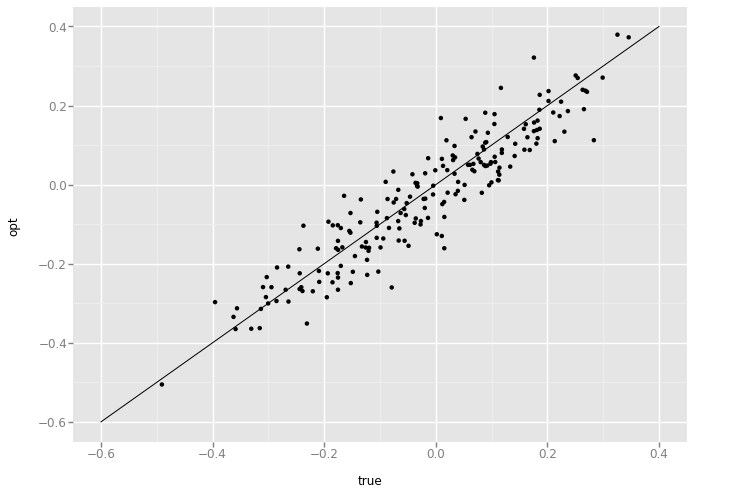

<ggplot: (8749384130521)>


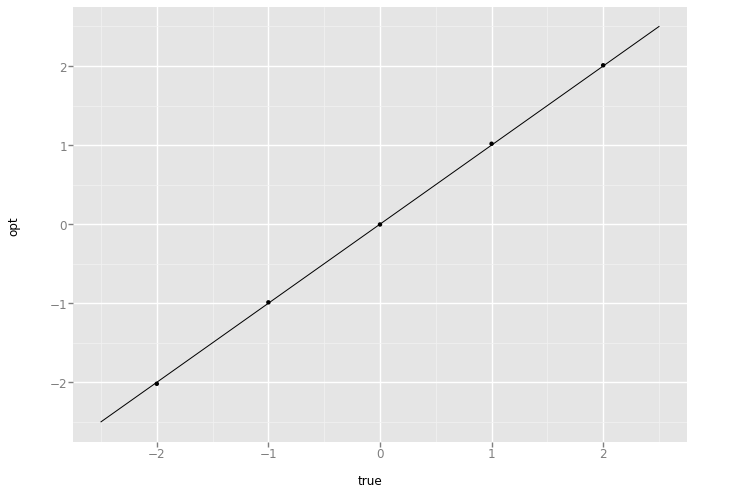

<ggplot: (8749376577149)>


In [97]:
# print(glmm_par_opt)
print '--------------- beta:\n'
print true_beta
print lmm_par_opt['beta'].e()

print '--------------- mu:\n'
print lmm_par_opt['mu'].e()[0]
print true_mu

print '--------------- mu info:\n'
print lmm_par_opt['mu_info'].e()[0]
print true_mu_info

print '--------------- y info:\n'
print lmm_par_opt['y_info'].e()[0]
print true_y_info


# Check the random effect estimates.  This requires simulated data.
from ggplot import *
import pandas as pd
%matplotlib inline

e_u = lmm_par_opt['u'].e()

plot_df = pd.DataFrame({ 'opt': lmm_par_opt['u'].e(), 'true': true_u })
print ggplot(plot_df, aes(x='true', y='opt')) + geom_point() + geom_abline(slope=1, intercept=0)

plot_df = pd.DataFrame({ 'opt': lmm_par_opt['beta'].e(), 'true': true_beta })
print ggplot(plot_df, aes(x='true', y='opt')) + geom_point() + geom_abline(slope=1, intercept=0)


In [95]:
# Slow, but probably faster than using CG if you want the covariance of many parameters.
hess_time = time.time()
print 'Calculating KL Hessian.\n'
kl_hess = KLHess(vb_opt.x)
hess_time =  time.time() - hess_time
elbo_hess = -kl_hess
print 'Done.\n'

print 'hess_time: %f' % hess_time

Calculating KL Hessian.

Done.

496273336.875
hess_time: 54.143301


In [105]:
hess_norm = np.sqrt(np.sum(kl_hess**2))
diag_norm = np.sqrt(np.sum(np.diag(kl_hess)**2))

# How diagonal is the Hessian?
print hess_norm 
print (hess_norm - diag_norm) / hess_norm

22277.1932001
0.000350886396672


In [94]:
moment_jac = MomentJacobian(vb_opt.x)
lrvb_cov = np.matmul(moment_jac, np.linalg.solve(kl_hess, moment_jac.T))

prior_indices = copy.deepcopy(prior_par)
prior_indices.set_vector(1 + np.array(range(prior_indices.vector_size())))

vp_indices = copy.deepcopy(lmm_par_opt)
vp_indices.set_vector(1 + np.array(range(vp_indices.vector_size())))